# Assignment 3
**COMP 4107 Fall 2017**

**Basim Ramadhan 100 901 646**

**Christian Abbott 100 863 049**

***

# Question 1

## Running Our Code

We prefer that you use our easy-to-use Makefile to test out our program:

In [ ]:
make prepare-venv
./env/bin/python hopfieldnet.py 4

Otherwise, if you have matplotlib, numpy, and scikit-learn installed already:

In [ ]:
# Syntax
python3 hopfieldnet.py <num-training-patterns>
# Example
python3 hopfieldnet.py 4

## Accuracy of Pattern Recovery / Classification

We experimented with the Hebb's and Storkey's learning rules for networks storing 1 - 20 images. For each number of images stored in the network, we repeated the experiment 30 times. In other words, our experimentation was the following:

* Train on 1 image with Hebb's rule and test the network's pattern recovery accuracy, 30 times.
* Train on 2 images with Hebb's rule and test the network's pattern recovery accuracy, 30 times.
* ...
* Train on 20 images with Hebb's rule and test the network's pattern recovery accuracy, 30 times.

* Train on 1 image with Storkey's rule and test the network's pattern recovery accuracy, 30 times.
* Train on 2 images with Storkey's rule and test the network's pattern recovery accuracy, 30 times.
* ...
* Train on 20 image with Storkey's rule and test the network's pattern recovery accuracy, 30 times.

These experiments yields the accuracy values in the code and chart below.

### Accuracy Chart

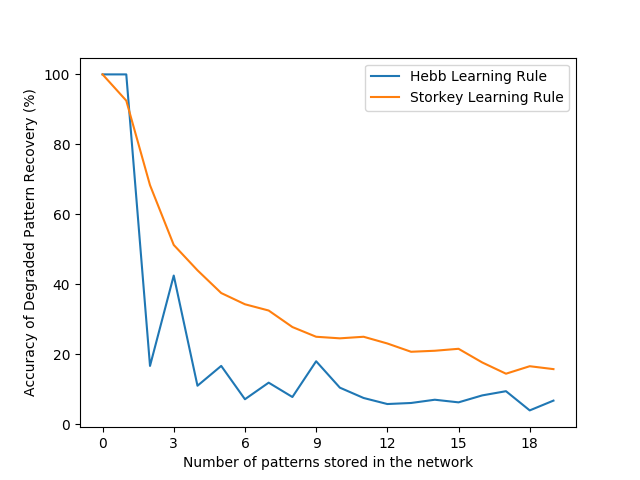

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

hebb_accuracy = [
    100.00, 100.00, 16.67, 42.50, 11.00,
    16.67, 7.14, 11.88, 7.78, 18.00,
    10.45, 7.50, 5.77, 6.07, 7.00,
    6.25, 8.24, 9.44, 3.95, 6.75
]
storkey_accuracy = [
    100.00, 92.50, 68.33, 51.25, 44.00,
    37.50, 34.29, 32.50, 27.78, 25.00,
    24.55, 25.00, 23.08, 20.71, 21.00,
    21.56, 17.65, 14.44, 16.58, 15.75
]

fig = plt.figure()
ax = fig.gca()

plt.plot(hebb_accuracy)
plt.plot(storkey_accuracy)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("Number of patterns stored in the network")
plt.ylabel("Accuracy of Degraded Pattern Recovery (%)")
plt.legend(['Hebb Learning Rule', 'Storkey Learning Rule'], loc='upper right')

plt.show()

### Analysis

Based on the data above, in addition to our experiences, we have the following conclusions:
* In general, training with Storkey's rule produces more accurate networks.
* Hebb's rule surprisingly works better for 2-image networks than Storkey's rule.
* Training with Hebb's rule (<1 second) is significantly faster than with Storkey's rule (~5 seconds).

## Implementation

### Learning Rule Implementations

For both learning rules, our initial implementations were simple and followed their respective definitions closely. These implementations were slow because they used nested for-loops with multiplications in each iteration. We then implemented optimized versions of the learning rules which used matrix operations instead. In the following code blocks we show both unoptimized and optimized implementations.

### Hebb's Learning Rule

In [ ]:
def train_hebbian(self, patterns):
    """Train the Hopfield network using the Hebbian learning rule (1949).
    https://en.wikipedia.org/wiki/Hopfield_network#Hebbian_learning_rule_for_Hopfield_networks
    """
    for p in patterns:
        a = p.reshape((self.shape, 1))
        b = a.T
        self.weights += np.dot(a, b)
    self.weights -= (np.identity(patterns[0].size) * patterns.shape[0])
    return self.weights

def train_hebbian_unoptimized(self, patterns):
    """Inefficient version of the train_hebbian function.
    Performs individual multiplications instead of efficient matrix operations."""
    n = self.shape
    for i, j in itertools.product(range(n), range(n)):
        self.weights[i][j] = sum([p[i] * p[j] for p in patterns]) / n
    return self.weights

### Storkey's Learning Rule

In [ ]:
def train_storkey(self, patterns):
    """Train the Hopfield network using the Storkey learning rule (1997).
    https://en.wikipedia.org/wiki/Hopfield_network#The_Storkey_learning_rule
    """
    n = self.shape
    for p in patterns:
        for i, j in itertools.product(range(n), range(n)):
            wt = self.weights
            w = wt[i][j]
            x = p[i] * p[j]
            y = p[i] * (np.dot(wt[j], p) - wt[j][i] * p[i] - wt[j][j] * p[j])
            z = p[j] * (np.dot(wt[i], p) - wt[i][i] * p[i] - wt[i][j] * p[j])
            wt[i][j] = w + ((x - y - z) / n)

def train_storkey_unoptimized(self, patterns):
    """Inefficient version of the train_storkey function.
    Performs individual multiplications instead of efficient matrix operations."""
    n = self.shape
    for p in patterns:
        for i, j in itertools.product(range(n), range(n)):
            w = self.weights[i][j]
            x = p[i] * p[j] / n
            y = p[i] * sum([self.weights[j][k] * p[k] for k in range(n) if k not in [i, j]]) / n
            z = p[j] * sum([self.weights[i][k] * p[k] for k in range(n) if k not in [i, j]]) / n
            self.weights[i][j] = w + x - y - z

### Activation

Our activation function follows the definition on the Wikipedia page.

In [ ]:
def activate(self, i):
    """Determine whether the given neuron should be active or inactive.
    https://en.wikipedia.org/wiki/Hopfield_network#Updating"""
    weight_sum = np.dot(self.weights[i], self.state)
    self.state[i] = 1 if weight_sum > self.thresholds[i] else -1

def activate_unoptimized(self, i):
    """Inefficient version of activate."""
    num_neurons = self.shape
    weight_sum = 0.0
    for j in range(num_neurons):
        weight_sum += self.weights[i][j] * self.state[j]
    self.state[i] = 1 if weight_sum > self.thresholds[i] else -1

### Recovery

We took our own approach to recovering degraded patterns. At each iteration, we call activate on each neuron in random order. If no state changes take place during a single iteration, then the network state is stable the image has (hopefully) been recovered.

In [ ]:
def restore(self, degraded_pattern):
    """Recover the original pattern of the degraded input pattern."""
    self.state = np.copy(degraded_pattern)
    num_neurons = self.shape

    # During each iteration: ensure each neuron is activated at least once
    iterations = 0
    while iterations < 10:
        changed = False
        neurons = list(range(num_neurons))
        random.shuffle(neurons)
        while neurons:
            neuron = neurons.pop()
            old_state = self.state[neuron]
            self.activate(neuron)
            new_state = self.state[neuron]
            changed = True if old_state != new_state else changed
        iterations += 1
        if not changed:
            break

    recovered_pattern = np.copy(self.state)
    return recovered_pattern

## Pattern Recovery Visualizations

### Recovery from Hebb-trained Networks

#### Success with 2-image Network

![hebb-recovery-01.png](figures/hebb-recovery-01.png)
![hebb-recovery-02.png](figures/hebb-recovery-02.png)

#### Failure with 9-image Network

![hebb-recovery-03.png](figures/hebb-recovery-03.png)
![hebb-recovery-04.png](figures/hebb-recovery-04.png)

### Recovery from Storkey-trained Networks

#### Success with 2-image Network

![storkey-recovery-01.png](figures/storkey-recovery-01.png)
![storkey-recovery-02.png](figures/storkey-recovery-02.png)

#### Success with 9-image Network

![storkey-recovery-03.png](figures/storkey-recovery-03.png)
![storkey-recovery-04.png](figures/storkey-recovery-04.png)

#### Failure with 9-image Network

![storkey-recovery-05.png](figures/storkey-recovery-05.png)
![storkey-recovery-06.png](figures/storkey-recovery-06.png)


## Network Visualizations

We visualized the Hopfield networks after being trained. We did this to get a better understanding of how the and Hebb and Storkey learning rules differ. We found that Hebb's rule produced a simpler, less-detailed network.

You can see this in the diagrams that follow: in Hebb-trained networks, the visualizations use fewer colors; this means that there's less information in the network. Meanwhile in Storkey-trained networks, the presence of more shades of color indicate a nuanced, more detailed network.

Furthermore, it's also interesting to visually see patterns stored in the network in the "Network State" visualizations. We did this visualization by summing the weights of each neuron to decide on the color; then plotting a 28x28 grid of neurons with their respective colors.

In both examples, two patterns were used to train the networks.

### Hebb-trained Network

![hebb-network-weights.png](figures/hebb-network-weights.png)
![hebb-network-state.png](figures/hebb-network-state.png)

### Storkey-trained Network

![storkey-network-weights.png](figures/storkey-network-weights.png)
![storkey-network-state.png](figures/storkey-network-state.png)

## References
The work we provided in our submission is our own.

* https://en.wikipedia.org/wiki/Hopfield_network
* http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.33.103&rep=rep1&type=pdf (Storkey's paper)
TODO